In [ ]:
# hide
from profetorch.model import Model

# ProFeTorch

> FB Prophet + Fastai + pyTorch.

This is an alternative implementation of prophet which uses quantile regression instead of MCMC sampling. It provides the following benefits over prophet:
- GPU usage.
- Strict(er) upper and lower bounds.
- Can add any other set of features to the time series.

The time series is implemented as follows:
$$
\begin{aligned}
y &= b(T(t) + S(t) + F(x)|l,u) \\
T(t) &= mt + a \\
S(t) &= \sum_{n=1}^N\left(a_n \cos\left(\frac{2\pi nt}{P}\right) + b_n \sin\left(\frac{2\pi nt}{P}\right)\right) \\
F(x) &= w^T x\\
b(y|l,u) &= \begin{cases}
l \quad \text{if } y < l \\
y \quad \text{if } l < y < u \\
u \quad \text{if } y > u
\end{cases}
\end{aligned}
$$

where $T(t)$ is the trend line, $S(t)$ are the seasonal components composed of a fourier sum, $F(x)$ is a linear function which weights features that is not related to time.

The task is therefore to find the parameters $a, m, \cup_n a_n, \cup_n b_n, w$ that minimises a loss function $l(\hat{y}, y)$. The default is set to minimise $l1$ loss $\frac{1}{N}\sum_{i=1}^N |y_i - \hat{y_i}|$ so that the reliance on outliers is minimised. By default we also calculate the 5th and 95th quantile by minimising the tilted loss function. The quantile functions are calculated as:
$$
\begin{aligned}
y_5 &= b(\hat{y} - (m_5 t + a_5)|l,u) \\
y_{95} &= b(\hat{y} + (m_{95} t + a_{95})|l,u)
\end{aligned}
$$

## Install

`pip install profetorch`

In [ ]:
# hide
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv"
df = pd.read_csv(url)
df['ds'] = pd.to_datetime(df['ds'])
print(df.shape)
df.head()

(2905, 2)


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


/opt/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


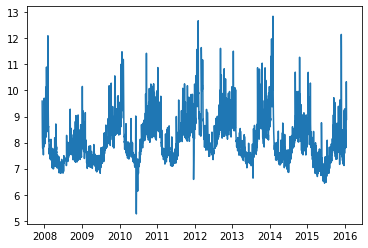

In [ ]:
# hide
plt.plot(df['ds'], df['y'])
plt.show()

In [ ]:
# hide
train_len = int(0.8*len(df))
train_df = df[:train_len]
test_df = df[train_len:]

## ProFeTorch Training

In [ ]:
model_params = {'y_n':10, 'm_n':7, 'l':0, 'h': train_df['y'].max() * 2}
model = Model(model_args=model_params, epochs=30, alpha=1e-2)
model.fit(train_df)

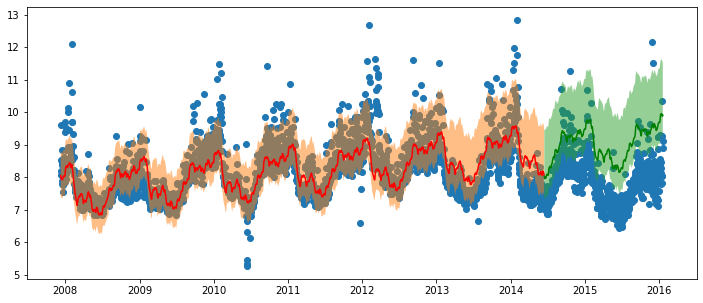

In [ ]:
y_pred = model.predict(df)
plt.figure(figsize=(12,5))
plt.scatter(df['ds'], df['y'], label='Data')
plt.plot(train_df['ds'], y_pred[:train_len,1], c='r', label='Train Set')
plt.fill_between(train_df['ds'], y_pred[:train_len,0], y_pred[:train_len,2], alpha=0.5)
plt.plot(test_df['ds'], y_pred[train_len:,1], c='g', label='Test Set')
plt.fill_between(test_df['ds'], y_pred[train_len:,0], y_pred[train_len:,2], alpha=0.5)
plt.show()

Obviously more works needs to be done as seen in the graph above. However, note that:
1. The seasonal component is captured.
2. The quantiles are asymmetric, which cannot happen in the fb-prophet case.
3. **I will fix these short comings if there is enough interest.**